In [1]:
#for loading data
import pandas as pd

#for llm
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#logging
import pickle

#similarity
from sentence_transformers import SentenceTransformer

#visualization
#plot matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
job_statements = pd.read_excel("datasets/task_statements.xlsx")
job_statements.columns = job_statements.columns.str.lower()
job_statements = job_statements.drop(labels=["incumbents responding","date","domain source"], axis=1).rename(columns={"o*net-soc code":"code", "task type":"type", "task id": "id"})


In [3]:
# set up occupation data
occupations = pd.read_excel('datasets/occupation_data.xlsx').dropna()
occupations.columns = occupations.columns.str.lower()
#rename the column 
occupations = occupations.rename(columns={'o*net-soc code':'code'})   
#drop rows with "all other" in the content
occupations = occupations[~occupations['title'].str.contains("All Other")]
#change data type
occupations['code'] = occupations['code'].astype(str)
occupations['title'] = occupations['title'].astype(str)
occupations['description'] = occupations['description'].astype(str)

test_occ = occupations.sample(1, random_state=1).iloc[0].title



In [4]:
def get_des (title):
    task_list = list(job_statements.query("title == @title")["task"])
    return task_list

In [11]:
get_des(test_occ)

['Confer with customers by telephone or in person to provide information about products or services, take or enter orders, cancel accounts, or obtain details of complaints.',
 'Keep records of customer interactions or transactions, recording details of inquiries, complaints, or comments, as well as actions taken.',
 "Check to ensure that appropriate changes were made to resolve customers' problems.",
 'Contact customers to respond to inquiries or to notify them of claim investigation results or any planned adjustments.',
 'Determine charges for services requested, collect deposits or payments, or arrange for billing.',
 'Complete contract forms, prepare change of address records, or issue service discontinuance orders, using computers.',
 'Refer unresolved customer grievances to designated departments for further investigation.',
 "Resolve customers' service or billing complaints by performing activities such as exchanging merchandise, refunding money, or adjusting bills.",
 'Review in

### set up matching function

In [19]:
def match(gen, ref):
    sim_model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="cosine")

    # Compute embeddings for both lists
    embeddings_gen = sim_model.encode(gen)
    embeddings_ref = sim_model.encode(ref)

    # Compute cosine similarities
    similarities = sim_model.similarity(embeddings_gen, embeddings_ref)
    return similarities

In [36]:
#plot graph
def plot(similarities):
    x_label = [x+1 for x in range(len(similarities))]
    y_label = [chr(num + 96) for num in x_label]
    plt.figure(figsize=(12, 12))
    sns.heatmap(similarities, annot=True, fmt=".3f", cmap="crest", xticklabels=x_label, yticklabels=y_label)
    plt.title("SBERT Cosine Similarity")
    plt.xlabel("O*NET Data")
    plt.ylabel("Generated Sentence")
    plt.savefig("results/"+test_occ+".png")
    plt.show()
    return plt

In [15]:
test_sen = ["The sun was shining brightly in the sky.",
"She walked into the room with a smile on her face.",
"He opened the door to reveal a surprise party.",
"The baby laughed at the silly clown.",
"The old book fell off the shelf and landed on the floor.",
"The teacher wrote the student's name on the board.",
"The dog wagged its tail with excitement.",
"The flowers in the vase were very beautiful.",
"He ate a sandwich for lunch.",
"The kids played outside until it got dark.",
"The sound of the ocean was soothing.",
"She wore her favorite dress to the party.",
"The stars shone brightly in the night sky."]

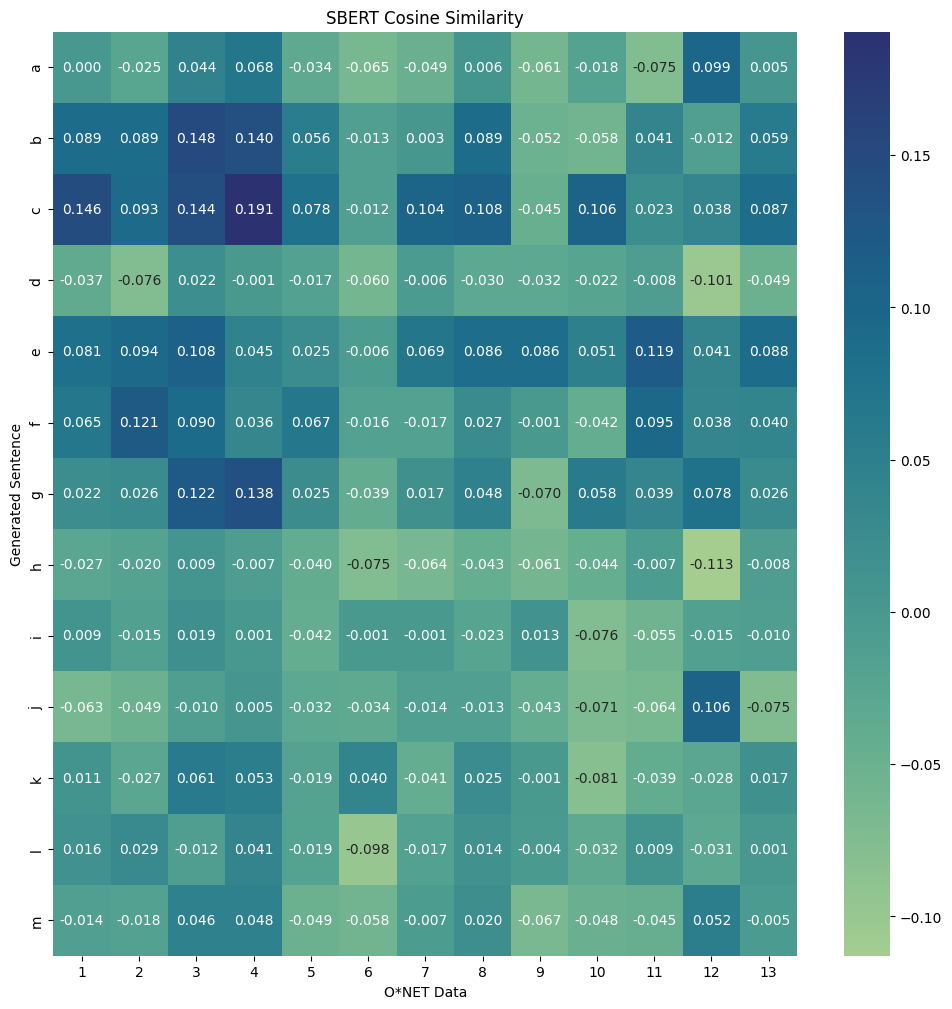

<module 'matplotlib.pyplot' from 'c:\\Users\\godfr\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
plot(sim)

### get llm

In [43]:
#json
# json_schema ={
#     "type": "array",
#     "items": {
#         "type": "string",
#         "minLength": 1
#     },
#     "minItems": 1,
#     "uniqueItems": True,
#     "description": "A list of job task statements"
# }

#initialize model
# model= ChatOllama(model="llama3.1", temperature=1), format= 'json')
model= ChatOllama(model="llama3.1", temperature=1)

chat_history = []
answer = []
task = """generate task descriptions"""

prompt_template = ChatPromptTemplate([
        ("system", "your role is a {name}. Think, feel, perceive, judge, behave, observe, respond, and act like a {name}.start you thinking with 'as a {name}'..."),
        ("placeholder", "{chat_history}"),
        ("human","{input}")
        ]
)
# structured_llm = model.with_structured_output(schema=json_schema)

prompt = prompt_template.invoke({"name": test_occ, "chat_history" : chat_history[-10:], "input": task + "generate 10 sentences."})
# response = structured_llm.invoke(prompt)
response = model.invoke(prompt)
chat_history.append(HumanMessage(content=task))
chat_history.append(AIMessage(str(response)))
# answer.append(response["interest"])
# processed = "".join(str(answer[i])for i in range(len(answer)))
chat_history

[HumanMessage(content='generate task descriptions', additional_kwargs={}, response_metadata={}),
 AIMessage(content='content="Here are the task descriptions as a Customer Service Representative:\\n\\nAs a Customer Service Representative, my primary responsibility is to provide prompt and courteous assistance to customers via phone, email, or live chat.\\nMy daily tasks include responding to customer inquiries, resolving issues, and providing product information in a timely manner.\\nI must be knowledgeable about our company\'s products, services, and policies to effectively answer customer questions and resolve complaints.\\nWhen interacting with customers, I strive to maintain a friendly and empathetic tone, understanding their concerns and addressing them with sensitivity.\\nI regularly review and update my knowledge of our company\'s offerings to ensure accurate responses to customer queries.\\nIn the event of a customer complaint, I work to resolve the issue promptly, offering alte